In [1]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
from sklearn.linear_model import \
(LinearRegression,
LogisticRegression,
Lasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import \
(train_test_split,
GridSearchCV)
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset
from torchmetrics import (MeanAbsoluteError,
R2Score,Accuracy)
from torchinfo import summary
from torchvision.io import read_image
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning import seed_everything
seed_everything(0, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)
from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import (resnet50,
ResNet50_Weights)
from torchvision.transforms import (Resize,
Normalize,
CenterCrop,
ToTensor)
from ISLP.torch import (SimpleDataModule,
SimpleModule,
ErrorTracker,
rec_num_workers)
from ISLP.torch.imdb import (load_lookup,
load_tensor,
load_sparse,
load_sequential)
from glob import glob
import json

Seed set to 0


In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from torchmetrics.classification import BinaryAccuracy

In [2]:
#############10.9.1 Single Layer Network on Hitters Data

In [3]:
Hitters = load_data('Hitters').dropna()
n = Hitters.shape[0]

In [4]:
model = MS(Hitters.columns.drop('Salary'), intercept=False)
X = model.fit_transform(Hitters).to_numpy()
Y = Hitters['Salary'].to_numpy()

In [5]:
(X_train,
X_test,
Y_train,
Y_test) = train_test_split(X,
                           Y,
                           test_size=1/3,
                           random_state=1)

In [6]:
# fit the linear model and evaluate the test error directly

In [7]:
hit_lm = LinearRegression().fit(X_train, Y_train)
Yhat_test = hit_lm.predict(X_test)
np.abs(Yhat_test - Y_test).mean()

259.71528833146226

In [8]:
# first normalize the features using a StandardScaler() transform, 
#then fit the lasso without further normalization.

In [9]:
scaler = StandardScaler(with_mean=True, with_std=True)
lasso = Lasso(warm_start=True, max_iter=30000)
standard_lasso = Pipeline(steps=[('scaler', scaler),
                                 ('lasso', lasso)])

In [10]:
#lam_max is the smallest value of λ with an allzero solution.
X_s = scaler.fit_transform(X_train)
n = X_s.shape[0]
lam_max = np.fabs(X_s.T.dot(Y_train - Y_train.mean())).max() / n
param_grid = {'alpha': np.exp(np.linspace(0, np.log(0.01), 100))
              * lam_max}

In [11]:
cv = KFold(10,
           shuffle=True,
           random_state=1)
grid = GridSearchCV(lasso,
                    param_grid,
                    cv=cv,
                    scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train);

In [12]:
trained_lasso = grid.best_estimator_
Yhat_test = trained_lasso.predict(X_test)
np.fabs(Yhat_test - Y_test).mean()

257.2382010799497

In [13]:
#########fit the neural network

In [14]:
#first set up a model structure that describes the network
class HittersModel(nn.Module):
    def __init__(self, input_size):
        super(HittersModel , self).__init__() #attached two objects to self as attributes: flatten and sequential/Using super() allows us to call the method of the base class
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(
            nn.Linear(input_size, 50),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(50, 1))
    def forward(self, x):
        x = self.flatten(x)
        return torch.flatten(self.sequential(x))

In [15]:
hit_model = HittersModel(X.shape[1])

In [16]:
summary(hit_model,
        input_size=X_train.shape,#specify the size of the input
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
HittersModel                             [175, 19]                 [175]                     --
├─Flatten: 1-1                           [175, 19]                 [175, 19]                 --
├─Sequential: 1-2                        [175, 19]                 [175, 1]                  --
│    └─Linear: 2-1                       [175, 19]                 [175, 50]                 1,000
│    └─ReLU: 2-2                         [175, 50]                 [175, 50]                 --
│    └─Dropout: 2-3                      [175, 50]                 [175, 50]                 --
│    └─Linear: 2-4                       [175, 50]                 [175, 1]                  51
Total params: 1,051
Trainable params: 1,051
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.18
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 0.00
Estimated Total Size (MB): 0.09

In [17]:
#need to transform our training data into a form accessible to torch.
X_train_t = torch.tensor(X_train.astype(np.float32))
Y_train_t = torch.tensor(Y_train.astype(np.float32))
hit_train = TensorDataset(X_train_t, Y_train_t)

X_test_t = torch.tensor(X_test.astype(np.float32))
Y_test_t = torch.tensor(Y_test.astype(np.float32))
hit_test = TensorDataset(X_test_t, Y_test_t)

In [18]:
#Finally, this dataset is passed to a DataLoader() which ultimately passes data into our network.

In [19]:
max_num_workers = rec_num_workers()

In [20]:
#The general training setup in pytorch_lightning involves training, validation and test data.
#During each epoch, we run a training step to learn the model and a validation step to track the error. 
#The test data is typically used at the end of training to evaluate the model.

In [21]:
# split only into test and training, we’ll use the test data as validation data with the argument validation=hit_test

In [22]:
#use the test data as validation data with the argument validation=hit_test
hit_dm = SimpleDataModule(hit_train,
                          hit_test,
                          batch_size=32, #At each step of SGD, the algorithm randomly selects 32 training observations for the computation of the gradient.
                          num_workers=min(4, max_num_workers),
                          validation=hit_test)

In [23]:
# squared-error loss as in (10.23)
hit_module = SimpleModule.regression(hit_model,
                                     metrics={'mae':MeanAbsoluteError()})

In [24]:
hit_logger = CSVLogger('logs', name='hitters')

In [25]:
hit_trainer = Trainer(deterministic=True,
                      max_epochs=50,
                      log_every_n_steps=5,
                      logger=hit_logger,
                      callbacks=[ErrorTracker()]) #enable us to compute validation error while training and, fnally, the test error.
hit_trainer.fit(hit_module, datamodule=hit_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | HittersModel | 1.1 K  | train
1 | loss  | MSELoss      | 0      | train
-----------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=50` reached.


In [26]:
#evaluate performance on our test data
hit_trainer.test(hit_module, datamodule=hit_dm)

Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │       107904.640625       │
│         test_mae          │    221.83148193359375     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 107904.640625, 'test_mae': 221.83148193359375}]

In [27]:
# create a plot of the MAE (mean absolute error) as a function of the number of epochs.
hit_results = pd.read_csv(hit_logger.experiment.metrics_file_path)

In [28]:
def summary_plot(results,
                 ax,
                 col='loss',
                 valid_legend='Validation',
                 training_legend='Training',
                 ylabel='Loss',
                 fontsize=20):
    for (column,
         color,
         label) in zip([f'train_{col}_epoch', f'valid_{col}'],
                       ['black',
                        'red'],
                       [training_legend,
                        valid_legend]):
        results.plot(x='epoch',
                     y=column,
                     label=label,
                     marker='o',
                     color=color,
                     ax=ax)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(ylabel)
        return ax

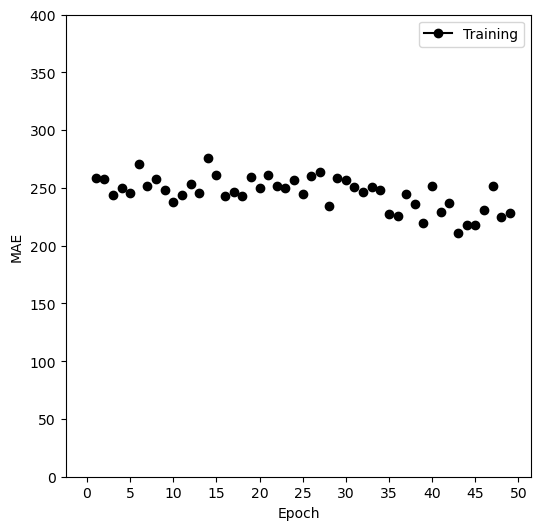

In [29]:
fig, ax = subplots(1, 1, figsize=(6, 6))
ax = summary_plot(hit_results,
                  ax,
                  col='mae',
                  ylabel='MAE',
                  valid_legend='Validation (=Test)')
ax.set_ylim([0, 400])
ax.set_xticks(np.linspace(0, 50, 11).astype(int));

In [30]:
hit_model.eval()
preds = hit_module(X_test_t)
torch.abs(Y_test_t - preds).mean()

tensor(221.8315, grad_fn=<MeanBackward0>)

In [31]:
#Cleanup
del(Hitters,
    hit_model, hit_dm,
    hit_logger,
    hit_test, hit_train,
    X, Y,
    X_test, X_train,
    Y_test, Y_train,
    X_test_t, Y_test_t,
    hit_trainer, hit_module)

In [32]:
#########10.9.2 Multilayer Network on the MNIST Digit Data

In [33]:
#1.first step is to retrieve the training and test data sets
(mnist_train,
 mnist_test) = [MNIST(root='data',
                      train=train,
                      download=True,
                      transform=ToTensor())
                for train in [True, False]]
mnist_train 

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [34]:
#transform each one into a vector
#setting aside 20% of the training images for validation
mnist_dm = SimpleDataModule(mnist_train,
                            mnist_test,
                            validation=0.2,
                            num_workers=max_num_workers,
                            batch_size=256)

In [35]:
#loop through the frst few chunks of the test dataset, breaking after 2 batches
for idx, (X_ ,Y_) in enumerate(mnist_dm.train_dataloader()):
    print('X: ', X_.shape)
    print('Y: ', Y_.shape)
    if idx >= 1:
        break

# the X for each batch consists of 256 images of size 1x28x28.

X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])
X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])


In [36]:
#For RGB images such as CIFAR100 below, we will see that the 1 in the size will be replaced by 3 for the three RGB channels

In [37]:
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.layer1 = nn.Sequential( # each 1x28x28 image is fattened, 
            nn.Flatten(),
            nn.Linear(28*28, 256), #then mapped to 256 dimensions  
            nn.ReLU(), #where we apply a ReLU activation
            nn.Dropout(0.4)) #with 40% dropout.
        self.layer2 = nn.Sequential(
            nn.Linear(256, 128), #maps the frst layer’s output down to 128 dimensions
            nn.ReLU(),
            nn.Dropout(0.3)) # applying a ReLU activation with 30% dropout
        self._forward = nn.Sequential(
            self.layer1,
            self.layer2,
            nn.Linear(128, 10)) # Finally, the 128 dimensions are mapped down to 10, the number of classes in the MNIST data.
    def forward(self, x):
        return self._forward(x)

In [38]:
mnist_model = MNISTModel()

In [39]:
#check that the model produces output of expected size based on our existing batch X_ above.
mnist_model(X_).size()

torch.Size([256, 10])

In [40]:
#pass a tensor of correct shape
summary(mnist_model,
        input_data=X_,
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
MNISTModel                               [256, 1, 28, 28]          [256, 10]                 --
├─Sequential: 1-1                        [256, 1, 28, 28]          [256, 10]                 --
│    └─Sequential: 2-1                   [256, 1, 28, 28]          [256, 256]                --
│    │    └─Flatten: 3-1                 [256, 1, 28, 28]          [256, 784]                --
│    │    └─Linear: 3-2                  [256, 784]                [256, 256]                200,960
│    │    └─ReLU: 3-3                    [256, 256]                [256, 256]                --
│    │    └─Dropout: 3-4                 [256, 256]                [256, 256]                --
│    └─Sequential: 2-2                   [256, 256]                [256, 128]                --
│    │    └─Linear: 3-5                  [256, 256]                [256, 128]                32,896
│    │    └─ReLU: 3-6     

In [41]:
#cross-entropy loss function

In [43]:
mnist_module = SimpleModule.classification(mnist_model, num_classes=10)
mnist_logger = CSVLogger('logs', name='MNIST')

In [44]:
# final step is to supply training data, and fit the model.
mnist_trainer = Trainer(deterministic=True,
                        max_epochs=30,
                        logger=mnist_logger,
                        callbacks=[ErrorTracker()])
mnist_trainer.fit(mnist_module,
                  datamodule=mnist_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | MNISTModel       | 235 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
235 K     Trainable params
0         Non-trainable params
235 K     Total params
0.941     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=30` reached.


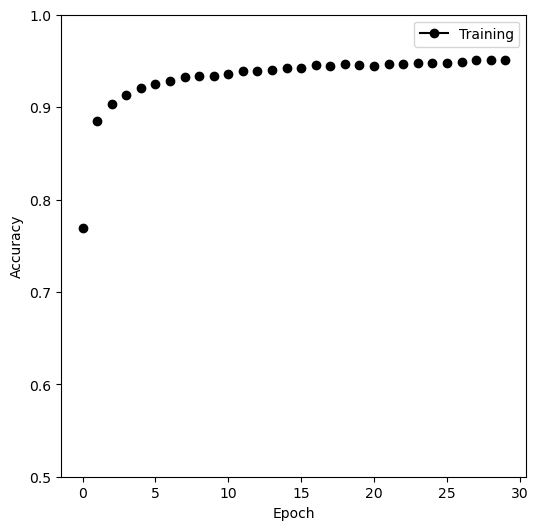

In [45]:
#summary_plot() function to display accuracy across epochs.
mnist_results = pd.read_csv(mnist_logger.experiment.
                            metrics_file_path)
fig, ax = subplots(1, 1, figsize=(6, 6))
summary_plot(mnist_results,
             ax,
             col='accuracy',
             ylabel='Accuracy')
ax.set_ylim([0.5, 1])
ax.set_ylabel('Accuracy')
ax.set_xticks(np.linspace(0, 30, 7).astype(int));

In [46]:
#evaluate the accuracy using the test() method of our trainer
mnist_trainer.test(mnist_module,
                   datamodule=mnist_dm)

Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9627000093460083     │
│         test_loss         │    0.15582838654518127    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.15582838654518127, 'test_accuracy': 0.9627000093460083}]

In [48]:
#the error rates resulting from LDA (Chapter 4) and multiclass logistic regression
# fit such a model with torch. We just have an input layer and an output layer, and omit the hidden layers
class MNIST_MLR(nn.Module):
    def __init__(self):
        super(MNIST_MLR, self).__init__()
        self.linear = nn.Sequential(nn.Flatten(),
                                    nn.Linear(784, 10))
    def forward(self, x):
        return self.linear(x)
mlr_model = MNIST_MLR()
mlr_module = SimpleModule.classification(mlr_model, num_classes=10)
mlr_logger = CSVLogger('logs', name='MNIST_MLR')

In [49]:
mlr_trainer = Trainer(deterministic=True,
                      max_epochs=30,
                      callbacks=[ErrorTracker()])
mlr_trainer.fit(mlr_module, datamodule=mnist_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | MNIST_MLR        | 7.9 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=30` reached.


In [50]:
mlr_trainer.test(mlr_module,
                 datamodule=mnist_dm)

Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9168999791145325     │
│         test_loss         │    0.3442913293838501     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3442913293838501, 'test_accuracy': 0.9168999791145325}]

In [ ]:
#delete some of the objects we created above

In [51]:
del(mnist_test,
    mnist_train,
    mnist_model,
    mnist_dm,
    mnist_trainer,
    mnist_module,
    mnist_results,
    mlr_model,
    mlr_module,
    mlr_trainer)

In [ ]:
###############10.9.3 Convolutional Neural Networks

In [ ]:
# ft a CNN to the CIFAR100 data

In [53]:
(cifar_train,
 cifar_test) = [CIFAR100(root="data",
                         train=train,
                         download=True)
                for train in [True, False]]

Failed download. Trying https -> http instead. Downloading http://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz to data/cifar-100-python.tar.gz


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 169001437/169001437 [02:13<00:00, 1269479.16it/s]


Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


In [54]:
transform = ToTensor()
cifar_train_X = torch.stack([transform(x) for x in
                             cifar_train.data])
cifar_test_X = torch.stack([transform(x) for x in
                            cifar_test.data])
cifar_train = TensorDataset(cifar_train_X,
                            torch.tensor(cifar_train.targets))
cifar_test = TensorDataset(cifar_test_X,
                           torch.tensor(cifar_test.targets))

In [ ]:
#The CIFAR100 dataset consists of 50,000 training images, each represented by a three-dimensional tensor

In [55]:
cifar_dm = SimpleDataModule(cifar_train,
                            cifar_test,
                            validation=0.2,
                            num_workers=max_num_workers,
                            batch_size=128)

In [56]:
for idx, (X_ ,Y_) in enumerate(cifar_dm.train_dataloader()):
    print('X: ', X_.shape)
    print('Y: ', Y_.shape)
    if idx >= 1:
        break

X:  torch.Size([128, 3, 32, 32])
Y:  torch.Size([128])
X:  torch.Size([128, 3, 32, 32])
Y:  torch.Size([128])


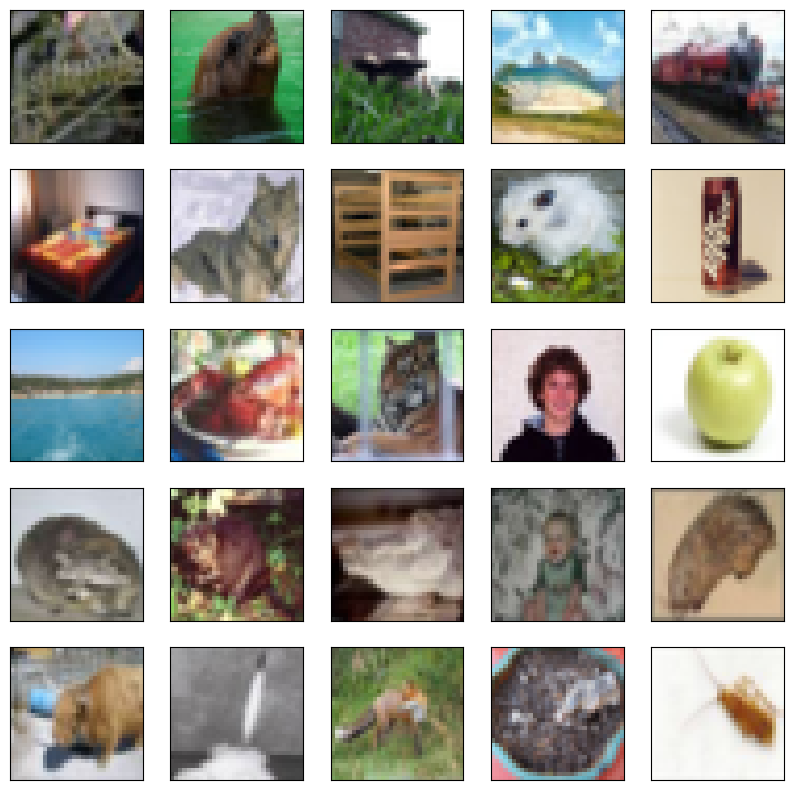

In [57]:
#choosing random images from the training data by indexing cifar_train
# reorder the dimensions by a call to np.transpose()
fig, axes = subplots(5, 5, figsize=(10,10))
rng = np.random.default_rng(4)
indices = rng.choice(np.arange(len(cifar_train)), 25,
                     replace=False).reshape((5,5))
for i in range(5):
    for j in range(5):
        idx = indices[i,j]
        axes[i,j].imshow(np.transpose(cifar_train[idx][0],
                                      [1,2,0]),
                         interpolation=None)
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])

In [ ]:
#We use several layers, each consisting of convolution, ReLU, and max-pooling steps.
#We use a 3 × 3 convolution flter for each channel in all the layers. Each convolution is followed by a max-pooling layer over 2 × 2 blocks.

In [60]:
class BuildingBlock(nn.Module):
    def __init__(self,
             in_channels,
             out_channels):
        super(BuildingBlock , self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=(3,3),
                              padding='same') #ensures that the output channels have the same dimension as the input channels
        self.activation = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
    def forward(self, x):
        return self.pool(self.activation(self.conv(x)))

In [61]:
class CIFARModel(nn.Module):
    def __init__(self):
        super(CIFARModel, self).__init__()
        sizes = [(3,32),
                 (32,64),
                 (64,128),
                 (128,256)]
        self.conv = nn.Sequential(*[BuildingBlock(in_, out_)
                                    for in_, out_ in sizes])
        self.output = nn.Sequential(nn.Dropout(0.5),
                                    nn.Linear(2*2*256, 512),
                                    nn.ReLU(),
                                    nn.Linear(512, 100))
    def forward(self, x):
        val = self.conv(x)
        val = torch.flatten(val, start_dim=1)
        return self.output(val)

In [62]:
#build the model and look at the summary.
cifar_model = CIFARModel()
summary(cifar_model,
        input_data=X_,
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CIFARModel                               [128, 3, 32, 32]          [128, 100]                --
├─Sequential: 1-1                        [128, 3, 32, 32]          [128, 256, 2, 2]          --
│    └─BuildingBlock: 2-1                [128, 3, 32, 32]          [128, 32, 16, 16]         --
│    │    └─Conv2d: 3-1                  [128, 3, 32, 32]          [128, 32, 32, 32]         896
│    │    └─ReLU: 3-2                    [128, 32, 32, 32]         [128, 32, 32, 32]         --
│    │    └─MaxPool2d: 3-3               [128, 32, 32, 32]         [128, 32, 16, 16]         --
│    └─BuildingBlock: 2-2                [128, 32, 16, 16]         [128, 64, 8, 8]           --
│    │    └─Conv2d: 3-4                  [128, 32, 16, 16]         [128, 64, 16, 16]         18,496
│    │    └─ReLU: 3-5                    [128, 64, 16, 16]         [128, 64, 16, 16]         --
│    │    └─MaxPool2d: 3-6    

In [64]:
cifar_optimizer = RMSprop(cifar_model.parameters(), lr=0.001)
cifar_module = SimpleModule.classification(cifar_model,
                                           optimizer=cifar_optimizer,
                                           num_classes=100,)
cifar_logger = CSVLogger('logs', name='CIFAR100')
cifar_trainer = Trainer(deterministic=True,
                        max_epochs=30,
                        logger=cifar_logger,
                        callbacks=[ErrorTracker()])
cifar_trainer.fit(cifar_module,
                  datamodule=cifar_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | CIFARModel       | 964 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
964 K     Trainable params
0         Non-trainable params
964 K     Total params
3.858     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=30` reached.


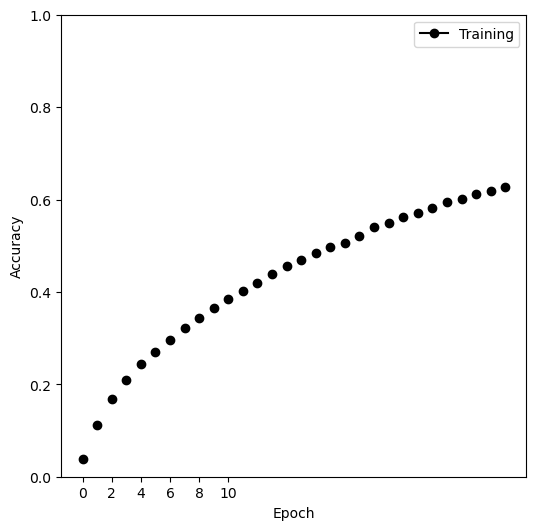

In [65]:
#take a look at the validation and training accuracy across epochs
log_path = cifar_logger.experiment.metrics_file_path
cifar_results = pd.read_csv(log_path)
fig, ax = subplots(1, 1, figsize=(6, 6))
summary_plot(cifar_results,
             ax,
             col='accuracy',
             ylabel='Accuracy')
ax.set_xticks(np.linspace(0, 10, 6).astype(int))
ax.set_ylabel('Accuracy')
ax.set_ylim([0, 1]);

In [66]:
#evaluate our model on our test data.
cifar_trainer.test(cifar_module,
                   datamodule=cifar_dm)

Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.4235999882221222     │
│         test_loss         │    2.3548357486724854     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.3548357486724854, 'test_accuracy': 0.4235999882221222}]

In [67]:
#Hardware Acceleration
try:
    for name, metric in cifar_module.metrics.items():
        cifar_module.metrics[name] = metric.to('mps')
        cifar_trainer_mps = Trainer(accelerator='mps',
                                    deterministic=True,
                                    max_epochs=30)
        cifar_trainer_mps.fit(cifar_module,
                              datamodule=cifar_dm)
        cifar_trainer_mps.test(cifar_module,
                               datamodule=cifar_dm)
except:
    pass

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | CIFARModel       | 964 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
964 K     Trainable params
0         Non-trainable params
964 K     Total params
3.858     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

/opt/anaconda3/lib/python3.11/site-packages/torchmetrics/functional/classification/accuracy.py:79: UserWarning: MPS: no support for int64 for sum_out_mps, downcasting to a smaller data type (int32/float32). Native support for int64 has been added in macOS 13.3. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1716905753263/work/aten/src/ATen/native/mps/operations/ReduceOps.mm:157.)
  tp = tp.sum(dim=0 if multidim_average == "global" else 1)


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=30` reached.


Testing: |                                                                                                    …

In [ ]:
###########10.9.4 Using Pretrained CNN Models

In [ ]:
#use a CNN pretrained on the imagenet database to classify natural images
# pretrained network we use is called resnet50

In [69]:
#read in the images and preprocess them
resize = Resize((232,232))
crop = CenterCrop(224)
normalize = Normalize([0.485,0.456,0.406],
                      [0.229,0.224,0.225])
imgfiles = sorted([f for f in glob('book_images/*')])
imgs = torch.stack([torch.div(crop(resize(read_image(f))), 255)
                    for f in imgfiles])
imgs = normalize(imgs)
imgs.size()

torch.Size([5, 3, 224, 224])

In [70]:
#read in code block 6. The model has 50 layers, with a fair bit of complexity
resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)
summary(resnet_model,
        input_data=imgs,
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/wenqian/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:50<00:00, 2.05MB/s]


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
ResNet                                   [5, 3, 224, 224]          [5, 1000]                 --
├─Conv2d: 1-1                            [5, 3, 224, 224]          [5, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [5, 64, 112, 112]         [5, 64, 112, 112]         128
├─ReLU: 1-3                              [5, 64, 112, 112]         [5, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [5, 64, 112, 112]         [5, 64, 56, 56]           --
├─Sequential: 1-5                        [5, 64, 56, 56]           [5, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [5, 64, 56, 56]           [5, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [5, 64, 56, 56]           [5, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [5, 64, 56, 56]           [5, 64, 56, 56]           128
│    │    └─ReLU: 3-3      

In [71]:
# set the mode to eval() to ensure that the model is ready to predict on new data
resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [72]:
# feed our six images through the fitted network.
img_preds = resnet_model(imgs)

In [73]:
#First we compute the probabilities by applying the softmax to the logits in img_preds.
img_probs = np.exp(np.asarray(img_preds.detach()))
img_probs /= img_probs.sum(1)[:,None]

In [75]:
labs = json.load(open('imagenet_class_index.json'))
class_labels = pd.DataFrame([(int(k), v[1]) for k, v in
                             labs.items()],
                            columns=['idx', 'label'])
class_labels = class_labels.set_index('idx')
class_labels = class_labels.sort_index()

In [76]:
# construct a data frame for each image fle with the labels with the three highest probabilities as estimated by the model above.
for i, imgfile in enumerate(imgfiles):
    img_df = class_labels.copy()
    img_df['prob'] = img_probs[i]
    img_df = img_df.sort_values(by='prob', ascending=False)[:3]
    print(f'Image: {imgfile}')
    print(img_df.reset_index().drop(columns=['idx']))

Image: book_images/Cape_Weaver.jpg
      label      prob
0   jacamar  0.297499
1     macaw  0.068107
2  lorikeet  0.051105
Image: book_images/Hawk_Fountain.jpg
            label      prob
0            kite  0.184682
1           robin  0.084021
2  great_grey_owl  0.061274
Image: book_images/Hawk_cropped.jpg
            label      prob
0            kite  0.453833
1  great_grey_owl  0.015914
2             jay  0.012210
Image: book_images/Lhasa_Apso.jpg
             label      prob
0            Lhasa  0.260317
1         Shih-Tzu  0.097196
2  Tibetan_terrier  0.032820
Image: book_images/Sleeping_Cat.jpg
         label      prob
0  Persian_cat  0.163070
1        tabby  0.074143
2    tiger_cat  0.042578


In [77]:
del(cifar_test,
    cifar_train,
    cifar_dm,
    cifar_module,
    cifar_logger,
    cifar_optimizer,
    cifar_trainer)

In [ ]:
###################10.9.5 IMDB Document Classifcation

In [78]:
# implement models for sentiment classifcation (Section 10.4) on the IMDB dataset
(imdb_seq_train,
 imdb_seq_test) = load_sequential(root='data/IMDB')
padded_sample = np.asarray(imdb_seq_train.tensors[0][0])
sample_review = padded_sample[padded_sample > 0][:12]
sample_review[:12]
#imdb_seq_train and imdb_seq_test are both instances of the class TensorDataset
#taken the frst row of features and stored it as padded_sample.

Retrieving "IMDB_S_train.tensor.gz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".
Retrieving "IMDB_S_test.tensor.gz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".
Retrieving "IMDB_Y_test.npy" from "http://imdb.jtaylor.su.domains/jtaylor/data/".
Retrieving "IMDB_Y_train.npy" from "http://imdb.jtaylor.su.domains/jtaylor/data/".


array([   1,   14,   22,   16,   43,  530,  973, 1622, 1385,   65,  458,
       4468], dtype=int32)

In [80]:
lookup = load_lookup(root='data/IMDB')
' '.join(lookup[i] for i in sample_review)

Retrieving "IMDB_word_index.pkl" from "http://imdb.jtaylor.su.domains/jtaylor/data/".


"<START> this film was just brilliant casting location scenery story direction everyone's"

In [82]:
#For our frst model, we have created a binary feature for each of the 10,000 possible words in the dataset, 
#with an entry of one in the i, j entry if word j appears in review i.
max_num_workers=10
(imdb_train,
imdb_test) = load_tensor(root='data/IMDB')
imdb_dm = SimpleDataModule(imdb_train,
                           imdb_test,
                           validation=2000,
                           num_workers=min(6, max_num_workers),
                           batch_size=512)

Retrieving "IMDB_X_test.tensor.gz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".
Retrieving "IMDB_X_train.tensor.gz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".


In [83]:
# use a two-layer model for our frst model.
class IMDBModel(nn.Module):
    def __init__(self, input_size):
        super(IMDBModel, self).__init__()
        self.dense1 = nn.Linear(input_size, 16)
        self.activation = nn.ReLU()
        self.dense2 = nn.Linear(16, 16)
        self.output = nn.Linear(16, 1)
    def forward(self, x):
        val = x
        for _map in [self.dense1,
                     self.activation,
                     self.dense2,
                     self.activation,
                     self.output]:
            val = _map(val)
        return torch.flatten(val)

In [84]:
#instantiate our model and look at a summary 
imdb_model = IMDBModel(imdb_test.tensors[0].size()[1])
summary(imdb_model,
        input_size=imdb_test.tensors[0].size(),
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
IMDBModel                                [25000, 10003]            [25000]                   --
├─Linear: 1-1                            [25000, 10003]            [25000, 16]               160,064
├─ReLU: 1-2                              [25000, 16]               [25000, 16]               --
├─Linear: 1-3                            [25000, 16]               [25000, 16]               272
├─ReLU: 1-4                              [25000, 16]               [25000, 16]               --
├─Linear: 1-5                            [25000, 16]               [25000, 1]                17
Total params: 160,353
Trainable params: 160,353
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 4.01
Input size (MB): 1000.30
Forward/backward pass size (MB): 6.60
Params size (MB): 0.64
Estimated Total Size (MB): 1007.54

In [85]:
#use a smaller learning rate for these data
imdb_optimizer = RMSprop(imdb_model.parameters(), lr=0.001)
imdb_module = SimpleModule.binary_classification(
    imdb_model,
    optimizer=imdb_optimizer)

In [86]:
imdb_logger = CSVLogger('logs', name='IMDB')
imdb_trainer = Trainer(deterministic=True,
                       max_epochs=30,
                       logger=imdb_logger,
                       callbacks=[ErrorTracker()])
imdb_trainer.fit(imdb_module,
                 datamodule=imdb_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | IMDBModel         | 160 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
160 K     Trainable params
0         Non-trainable params
160 K     Total params
0.641     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

/opt/anaconda3/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (45) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=30` reached.


In [87]:
#Evaluating the test error yields roughly 86% accuracy
test_results = imdb_trainer.test(imdb_module, datamodule=imdb_dm)
test_results

Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8514800071716309     │
│         test_loss         │    0.9721285700798035     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.9721285700798035, 'test_accuracy': 0.8514800071716309}]

In [93]:
############Comparison to Lasso
((X_train, Y_train),
(X_valid, Y_valid),
(X_test, Y_test)) = load_sparse(validation=2000,
                                random_state=0,
                                root='data/IMDB')

#construct a series of 50 values for the lasso reguralization parameter λ.
lam_max = np.abs(X_train.T * (Y_train - Y_train.mean())).max()
lam_val = lam_max * np.exp(np.linspace(np.log(1),
                                       np.log(1e-4), 50))

logit = LogisticRegression(penalty='l1',
                           C=1/lam_max,
                           solver='liblinear',
                           warm_start=True,
                           fit_intercept=True)

coefs = []
intercepts = []
for l in lam_val:
    logit.C = 1/l
    logit.fit(X_train, Y_train)
    coefs.append(logit.coef_.copy())
    intercepts.append(logit.intercept_)

# coefcient and intercepts have an extraneous dimension which can be removed by the np.squeeze()
coefs = np.squeeze(coefs)
intercepts = np.squeeze(intercepts)

In [96]:
%%capture
#make a plot to compare our neural network results with the lasso.
fig, axes = subplots(1, 2, figsize=(16, 8), sharey=True)
for ((X_, Y_),
     data_,
     color) in zip([(X_train, Y_train),
                    (X_valid, Y_valid),
                    (X_test, Y_test)],
                   ['Training', 'Validation', 'Test'],
                   ['black', 'red', 'blue']):
    linpred_ = X_ * coefs.T + intercepts[None,:]
    label_ = np.array(linpred_ > 0)
    accuracy_ = np.array([np.mean(Y_ == l) for l in label_.T])
    axes[0].plot(-np.log(lam_val / X_train.shape[0]),
                 accuracy_,
                 '.--',
                 color=color,
                 markersize=13,
                 linewidth=2,
                 label=data_)
axes[0].legend()
axes[0].set_xlabel(r'$-\log(\lambda)$', fontsize=20)
axes[0].set_ylabel('Accuracy', fontsize=20)

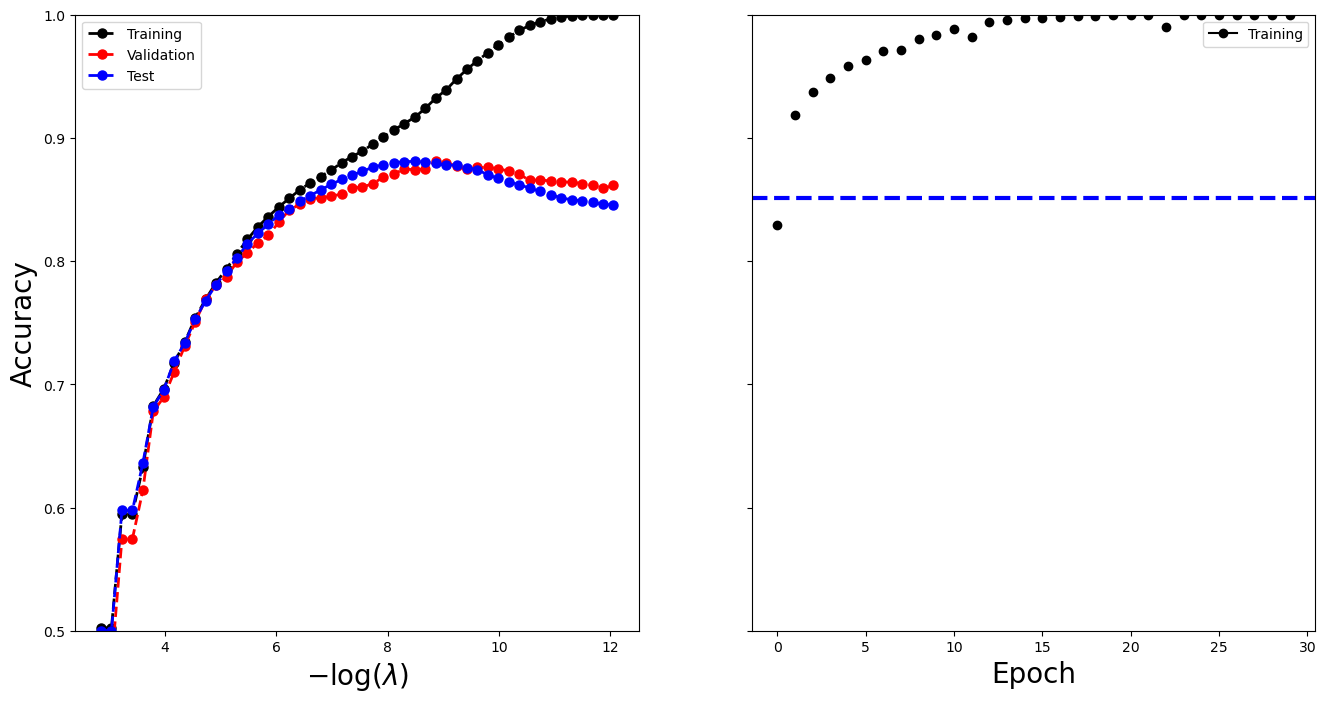

In [97]:
# add a plot of the lasso accuracy, 
#and display the composed fgure by simply entering its name at the end of the cell.
imdb_results = pd.read_csv(imdb_logger.experiment.metrics_file_path)
summary_plot(imdb_results,
             axes[1],
             col='accuracy',
             ylabel='Accuracy')
axes[1].set_xticks(np.linspace(0, 30, 7).astype(int))
axes[1].set_ylabel('Accuracy', fontsize=20)
axes[1].set_xlabel('Epoch', fontsize=20)
axes[1].set_ylim([0.5, 1]);
axes[1].axhline(test_results[0]['test_accuracy'],
                color='blue',
                linestyle='--',
                linewidth=3)
fig

In [98]:
del(imdb_model,
    imdb_trainer,
    imdb_logger,
    imdb_dm,
    imdb_train,
    imdb_test)

In [ ]:
##################10.9.6 Recurrent Neural Networks

In [99]:
#Here we fit a simple LSTM RNN for sentiment prediction to the IMDb movie-review data
imdb_seq_dm = SimpleDataModule(imdb_seq_train,
                               imdb_seq_test,
                               validation=2000,
                               batch_size=300,
                               num_workers=min(6, max_num_workers)
                              )

In [100]:
class LSTMModel(nn.Module):
    def __init__(self, input_size):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_size, 32) # an embedding layer of size 32 #one-hot encodes each document as a matrix of dimension 500×10003, and then maps these 10003 dimensions down to 32.
        self.lstm = nn.LSTM(input_size=32,
                            hidden_size=32,
                            batch_first=True) #an LSTM with 32 units
        self.dense = nn.Linear(32, 1) #output layer is a single logit for the binary classifcation task.
    def forward(self, x):
        val, (h_n, c_n) = self.lstm(self.embedding(x))
        return torch.flatten(self.dense(val[:,-1]))

In [101]:
#We instantiate and take a look at the summary of the model, using the first 10 documents in the corpus.
lstm_model = LSTMModel(X_test.shape[-1])
summary(lstm_model,
        input_data=imdb_seq_train.tensors[0][:10],
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
LSTMModel                                [10, 500]                 [10]                      --
├─Embedding: 1-1                         [10, 500]                 [10, 500, 32]             320,096
├─LSTM: 1-2                              [10, 500, 32]             [10, 500, 32]             8,448
├─Linear: 1-3                            [10, 32]                  [10, 1]                   33
Total params: 328,577
Trainable params: 328,577
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 45.44
Input size (MB): 50.00
Forward/backward pass size (MB): 2.56
Params size (MB): 1.31
Estimated Total Size (MB): 53.87

In [102]:
lstm_module = SimpleModule.binary_classification(lstm_model)
lstm_logger = CSVLogger('logs', name='IMDB_LSTM')
lstm_trainer = Trainer(deterministic=True,
                       max_epochs=20,
                       logger=lstm_logger,
                       callbacks=[ErrorTracker()])
lstm_trainer.fit(lstm_module,
                 datamodule=imdb_seq_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | LSTMModel         | 328 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
328 K     Trainable params
0         Non-trainable params
328 K     Total params
1.314     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=20` reached.


In [103]:
lstm_trainer.test(lstm_module, datamodule=imdb_seq_dm)

Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8564800024032593     │
│         test_loss         │    0.7938435673713684     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.7938435673713684, 'test_accuracy': 0.8564800024032593}]

(0.5, 1.0)

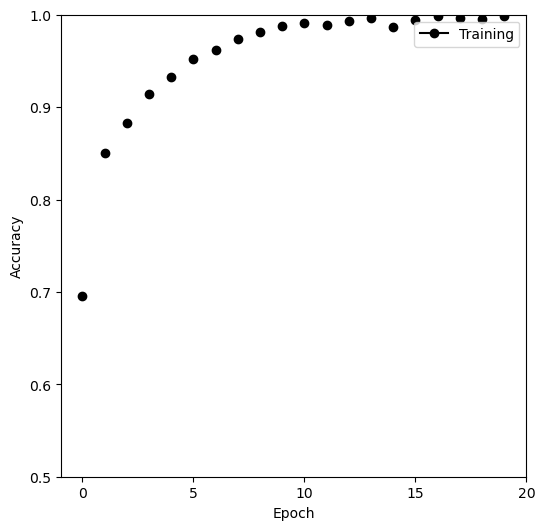

In [104]:
#show the learning progress, followed by cleanup
lstm_results = pd.read_csv(lstm_logger.experiment.metrics_file_path)
fig, ax = subplots(1, 1, figsize=(6, 6))
summary_plot(lstm_results,
             ax,
             col='accuracy',
             ylabel='Accuracy')
ax.set_xticks(np.linspace(0, 20, 5).astype(int))
ax.set_ylabel('Accuracy')
ax.set_ylim([0.5, 1])

In [105]:
del(lstm_model,
    lstm_trainer,
    lstm_logger,
    imdb_seq_dm,
    imdb_seq_train,
    imdb_seq_test)

In [106]:
############Time Series Prediction
NYSE = load_data('NYSE')
cols = ['DJ_return', 'log_volume', 'log_volatility']
X = pd.DataFrame(StandardScaler(
    with_mean=True,
    with_std=True).fit_transform(NYSE[cols]),
                 columns=NYSE[cols].columns,
                 index=NYSE.index)

In [107]:
#set up the lagged versions of the data, dropping any rows with missing values using the dropna() method
for lag in range(1, 6):
    for col in cols:
        newcol = np.zeros(X.shape[0]) * np.nan
        newcol[lag:] = X[col].values[:-lag]
        X.insert(len(X.columns), "{0}_{1}".format(col, lag), newcol)
X.insert(len(X.columns), 'train', NYSE['train'])
X = X.dropna()

In [108]:
#Finally, we extract the response, training indicator, and drop the current day’s DJ_return 
#and log_volatility to predict only from previous day’s data.
Y, train = X['log_volume'], X['train']
X = X.drop(columns=['train'] + cols)
X.columns

Index(['DJ_return_1', 'log_volume_1', 'log_volatility_1', 'DJ_return_2',
       'log_volume_2', 'log_volatility_2', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_4', 'log_volume_4', 'log_volatility_4',
       'DJ_return_5', 'log_volume_5', 'log_volatility_5'],
      dtype='object')

In [110]:
# fit a simple linear model and compute the R2 on the test data using the score() method.
M = LinearRegression()
M.fit(X[train], Y[train])
M.score(X[~train], Y[~train])

0.4128912938562521

In [111]:
#reft this model, including the factor variable day_of_week
X_day = pd.merge(X,
                 pd.get_dummies(NYSE['day_of_week']),
                 on='date')

In [112]:
# do not have to reinstantiate the linear regression model as its fit() method accepts a design matrix and a response directly
M.fit(X_day[train], Y[train])
M.score(X_day[~train], Y[~train])
#This model achieves an R2 of about 46%.

0.4595563133053274

In [ ]:
#To fit the RNN, we must reshape the data, as it will expect 5 lagged versions of each feature as indicated by the input_shape argument to the
#layer nn.RNN() below.
#For an input shape (5,3), each row represents a lagged version of the three variables.

In [113]:
ordered_cols = []
for lag in range(5,0,-1):
    for col in cols:
        ordered_cols.append('{0}_{1}'.format(col, lag))
X = X.reindex(columns=ordered_cols)
X.columns

Index(['DJ_return_5', 'log_volume_5', 'log_volatility_5', 'DJ_return_4',
       'log_volume_4', 'log_volatility_4', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_2', 'log_volume_2', 'log_volatility_2',
       'DJ_return_1', 'log_volume_1', 'log_volatility_1'],
      dtype='object')

In [114]:
# reshape the data
X_rnn = X.to_numpy().reshape((-1,5,3))
X_rnn.shape
#By specifying the frst size as -1, numpy.reshape() deduces its size based on the remaining arguments.

(6046, 5, 3)

In [115]:
class NYSEModel(nn.Module):
    def __init__(self):
        super(NYSEModel, self).__init__()
        self.rnn = nn.RNN(3,
                          12,
                          batch_first=True) #uses 12 hidden units
        self.dense = nn.Linear(12, 1) 
        self.dropout = nn.Dropout(0.1) #10% dropout
    def forward(self, x):
        val, h_n = self.rnn(x)
        val = self.dense(self.dropout(val[:,-1])) #extract the fnal time point as val[:,-1] in forward()
        return torch.flatten(val)
nyse_model = NYSEModel()

In [116]:
datasets = []
for mask in [train,~train]:
    X_rnn_t = torch.tensor(X_rnn[mask].astype(np.float32))
    Y_t = torch.tensor(Y[mask].astype(np.float32))
    datasets.append(TensorDataset(X_rnn_t, Y_t))
nyse_train, nyse_test = datasets

In [117]:
summary(nyse_model,
        input_data=X_rnn_t,
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
NYSEModel                                [1770, 5, 3]              [1770]                    --
├─RNN: 1-1                               [1770, 5, 3]              [1770, 5, 12]             204
├─Dropout: 1-2                           [1770, 12]                [1770, 12]                --
├─Linear: 1-3                            [1770, 12]                [1770, 1]                 13
Total params: 217
Trainable params: 217
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.83
Input size (MB): 0.11
Forward/backward pass size (MB): 0.86
Params size (MB): 0.00
Estimated Total Size (MB): 0.97

In [118]:
#put the two datasets into a data module, with a batch size of 64
nyse_dm = SimpleDataModule(nyse_train,
                           nyse_test,
                           num_workers=min(4, max_num_workers),
                           validation=nyse_test,
                           batch_size=64)

In [119]:
#run some data through our model to be sure the sizes match up correctly
for idx, (x, y) in enumerate(nyse_dm.train_dataloader()):
    out = nyse_model(x)
    print(y.size(), out.size())
    if idx >= 2:
        break

torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])


In [120]:
# requesting the R2 metric to be be computed at each epoch.
nyse_optimizer = RMSprop(nyse_model.parameters(),
                         lr=0.001)
nyse_module = SimpleModule.regression(nyse_model,
                                      optimizer=nyse_optimizer,
                                      metrics={'r2':R2Score()})

In [121]:
#The results on the test data are very similar to the linear AR model.
nyse_trainer = Trainer(deterministic=True,
                       max_epochs=200,
                       callbacks=[ErrorTracker()])
nyse_trainer.fit(nyse_module,
                 datamodule=nyse_dm)
nyse_trainer.test(nyse_module,
                  datamodule=nyse_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | NYSEModel | 217    | train
1 | loss  | MSELoss   | 0      | train
--------------------------------------------
217       Trainable params
0         Non-trainable params
217       Total params
0.001     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=200` reached.


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.6154901385307312     │
│          test_r2          │    0.4158697724342346     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6154901385307312, 'test_r2': 0.4158697724342346}]

In [123]:
#We could also ft a model without the nn.RNN() layer by just using a nn.Flatten() layer instead. This would be a nonlinear AR model.
datasets = []
for mask in [train, ~train]:
    X_day_t = torch.tensor(
        np.asarray(X_day[mask]).astype(np.float32))
    Y_t = torch.tensor(np.asarray(Y[mask]).astype(np.float32))
    datasets.append(TensorDataset(X_day_t, Y_t))
day_train, day_test = datasets

In [124]:
day_dm = SimpleDataModule(day_train,
                          day_test,
                          num_workers=min(4, max_num_workers),
                          validation=day_test,
                          batch_size=64)

In [125]:
#build a NonLinearARModel() that takes as input the 20 features and a hidden layer with 32 units
class NonLinearARModel(nn.Module):
    def __init__(self):
        super(NonLinearARModel , self).__init__()
        self._forward = nn.Sequential(nn.Flatten(),
                                      nn.Linear(20, 32),
                                      nn.ReLU(),
                                      nn.Dropout(0.5),
                                      nn.Linear(32, 1))
    def forward(self, x):
        return torch.flatten(self._forward(x))

In [126]:
nl_model = NonLinearARModel()
nl_optimizer = RMSprop(nl_model.parameters(),
                       lr=0.001)
nl_module = SimpleModule.regression(nl_model,
                                    optimizer=nl_optimizer,
                                    metrics={'r2':R2Score()})

In [127]:
nl_trainer = Trainer(deterministic=True,
                     max_epochs=20,
                     callbacks=[ErrorTracker()])
nl_trainer.fit(nl_module, datamodule=day_dm)
nl_trainer.test(nl_module, datamodule=day_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | NonLinearARModel | 705    | train
1 | loss  | MSELoss          | 0      | train
---------------------------------------------------
705       Trainable params
0         Non-trainable params
705       Total params
0.003     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=20` reached.


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5636278986930847     │
│          test_r2          │    0.4650896191596985     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5636278986930847, 'test_r2': 0.4650896191596985}]

In [ ]:
############# Exercises

In [ ]:
#6. Consider the simple function R(β) = sin(β) + β/10.

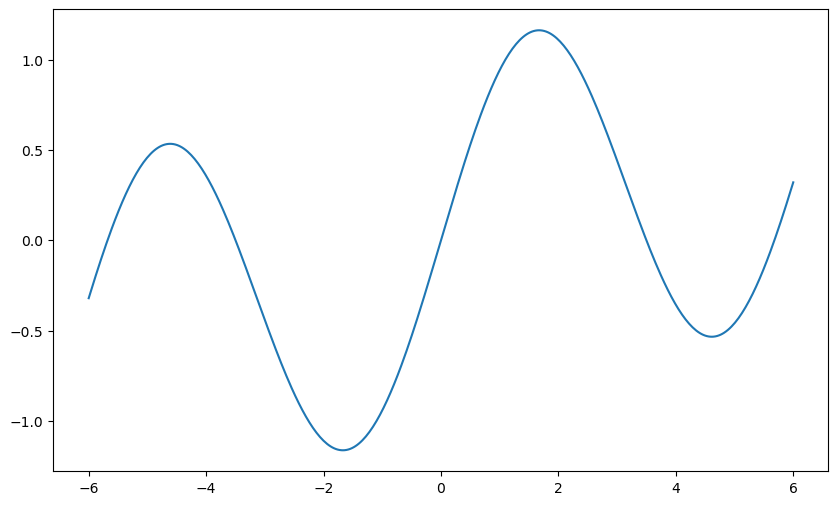

In [130]:
b = np.linspace(-6, 6, 400)
def R(beta):
    return np.sin(beta) + beta / 10
R_b = R(b)
plt.figure(figsize=(10, 6))
plt.plot(b, R_b, label='R(β) = sin(β) + β/10')

In [131]:
def dR(beta):
    return np.cos(beta) + 0.1

In [132]:
def gradient_descent(initial_beta, learning_rate, num_iterations):
    beta = initial_beta
    beta_history = [beta]  
    
    for i in range(num_iterations):
        grad = dR(beta)
        beta -= learning_rate * grad
        beta_history.append(beta)
        
    return np.array(beta_history)


In [156]:
learning_rate = 0.1
num_iterations = 100
initial_betas = [2.3, 1.4]

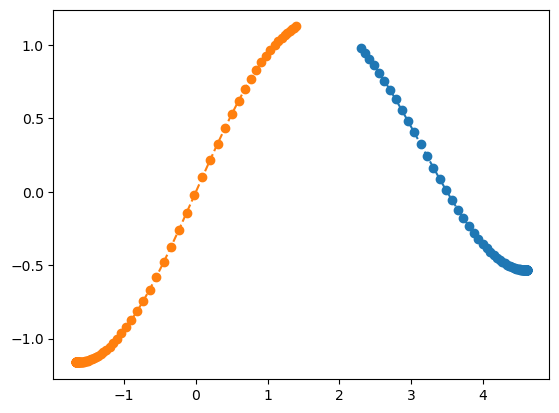

In [157]:
for initial_beta in initial_betas:
    beta_history = gradient_descent(initial_beta, learning_rate, num_iterations)
    plt.scatter(beta_history, R(beta_history), label=f'Gradient descent from β0 = {initial_beta}')
    plt.plot(beta_history, R(beta_history), linestyle='--')

In [159]:
for initial_beta in initial_betas:
    final_beta = gradient_descent(initial_beta, learning_rate, num_iterations)[-1]
    print(f"Final β after gradient descent from β0 = {initial_beta}: {final_beta:.4f}")

Final β after gradient descent from β0 = 2.3: 4.6120
Final β after gradient descent from β0 = 1.4: -1.6705


In [ ]:
#7. Fit a neural network to the Default data.

In [8]:
Default = load_data("Default")

In [35]:
n = Default.shape[0]
model = MS(Default.columns.drop('default'), intercept=False)
X = model.fit_transform(Default).to_numpy()
Y = Default['default'].to_numpy()
(X_train,
X_test,
Y_train,
Y_test) = train_test_split(X,
                           Y,
                           test_size=1/5,
                           random_state=1)

#. Use a single hidden layerwith 10 units, and dropout regularization
class DefaultModel(nn.Module):
    def __init__(self, input_size):
        super(DefaultModel , self).__init__() 
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(
            nn.Linear(input_size, 10),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(10, 1),
            nn.Sigmoid())
    def forward(self, x):
        x = self.flatten(x)
        return torch.flatten(self.sequential(x))

default_model = DefaultModel(X.shape[1])

summary(default_model,
        input_size=X_train.shape,#specify the size of the input
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
DefaultModel                             [8000, 3]                 [8000]                    --
├─Flatten: 1-1                           [8000, 3]                 [8000, 3]                 --
├─Sequential: 1-2                        [8000, 3]                 [8000, 1]                 --
│    └─Linear: 2-1                       [8000, 3]                 [8000, 10]                40
│    └─ReLU: 2-2                         [8000, 10]                [8000, 10]                --
│    └─Dropout: 2-3                      [8000, 10]                [8000, 10]                --
│    └─Linear: 2-4                       [8000, 10]                [8000, 1]                 11
│    └─Sigmoid: 2-5                      [8000, 1]                 [8000, 1]                 --
Total params: 51
Trainable params: 51
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.41
Input size (MB): 0.10
Forward

In [36]:
#need to transform our training data into a form accessible to torch.
Y_train = np.where(Y_train == 'No', 0, 1).astype(np.float32)  
Y_test = np.where(Y_test == 'No', 0, 1).astype(np.float32)

X_train_t = torch.tensor(X_train.astype(np.float32))
Y_train_t = torch.tensor(Y_train)
default_train = TensorDataset(X_train_t, Y_train_t)

X_test_t = torch.tensor(X_test.astype(np.float32))
Y_test_t = torch.tensor(Y_test)
default_test = TensorDataset(X_test_t, Y_test_t)

max_num_workers = rec_num_workers()


default_dm = SimpleDataModule(default_train,
                              default_test,
                              batch_size=32, 
                              num_workers=min(4, max_num_workers),
                              validation= default_test)


In [37]:
default_module = SimpleModule.classification(default_model,
                                             metrics={'accuracy': BinaryAccuracy()},
                                             num_classes=2)

default_logger = CSVLogger('logs', name='defaults')

default_trainer = Trainer(deterministic=True,
                      max_epochs=50,
                      log_every_n_steps=5,
                      logger=default_logger,
                      callbacks=[ErrorTracker()]) #enable us to compute validation error while training and, fnally, the test error.
default_trainer.fit(default_module, datamodule=default_dm)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | DefaultModel     | 51     | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
51        Trainable params
0         Non-trainable params
51        Total params
0.000     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=50` reached.


In [38]:
#evaluate performance on our test data
default_trainer.test(default_module, datamodule=default_dm)

Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9704999923706055     │
│         test_loss         │     448.4532470703125     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 448.4532470703125, 'test_accuracy': 0.9704999923706055}]

In [39]:
log_reg = LogisticRegression()
log_reg.fit(X_train, Y_train)
y_pred_log = log_reg.predict(X_test)
accuracy_score(Y_test, y_pred_log)

0.967

In [ ]:
#simple Neural Network Architecture
#small Dataset
#In binary classification tasks with simple linear boundaries, logistic regression can perform nearly as well as a neural network

In [176]:
#8. From your collection of personal photographs, pick 10 images of animals

In [31]:
#read in the images and preprocess them
resize = Resize((232,232))
crop = CenterCrop(224)
normalize = Normalize([0.485,0.456,0.406],
                      [0.229,0.224,0.225])
imgfiles = sorted([f for f in glob('animal_images/*')])

In [32]:
imgs = torch.stack([torch.div(crop(resize(read_image(f))), 255)
                    for f in imgfiles])
imgs = normalize(imgs)
imgs.size()

torch.Size([10, 3, 224, 224])

In [33]:
#read in code block 6. The model has 50 layers, with a fair bit of complexity
resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)
summary(resnet_model,
        input_data=imgs,
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
ResNet                                   [10, 3, 224, 224]         [10, 1000]                --
├─Conv2d: 1-1                            [10, 3, 224, 224]         [10, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [10, 64, 112, 112]        [10, 64, 112, 112]        128
├─ReLU: 1-3                              [10, 64, 112, 112]        [10, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [10, 64, 112, 112]        [10, 64, 56, 56]          --
├─Sequential: 1-5                        [10, 64, 56, 56]          [10, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [10, 64, 56, 56]          [10, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [10, 64, 56, 56]          [10, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2             [10, 64, 56, 56]          [10, 64, 56, 56]          128
│    │    └─ReLU: 3-3      

In [34]:
# set the mode to eval() to ensure that the model is ready to predict on new data
resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [35]:
# feed our six images through the fitted network.
img_preds = resnet_model(imgs)
#First we compute the probabilities by applying the softmax to the logits in img_preds.
img_probs = np.exp(np.asarray(img_preds.detach()))
img_probs /= img_probs.sum(1)[:,None]
labs = json.load(open('imagenet_class_index.json'))
class_labels = pd.DataFrame([(int(k), v[1]) for k, v in
                             labs.items()],
                            columns=['idx', 'label'])
class_labels = class_labels.set_index('idx')
class_labels = class_labels.sort_index()

In [36]:
# construct a data frame for each image fle with the labels with the three highest probabilities as estimated by the model above.
for i, imgfile in enumerate(imgfiles):
    img_df = class_labels.copy()
    img_df['prob'] = img_probs[i]
    img_df = img_df.sort_values(by='prob', ascending=False)[:5]
    print(f'Image: {imgfile}')
    print(img_df.reset_index().drop(columns=['idx']))

Image: animal_images/IMG_4037.JPG
                label      prob
0  Labrador_retriever  0.126742
1    golden_retriever  0.104752
2          bath_towel  0.023082
3                chow  0.009529
4              kuvasz  0.008820
Image: animal_images/IMG_4191.JPG
         label      prob
0       packet  0.111336
1       carton  0.070578
2       bucket  0.036734
3   shower_cap  0.016909
4  plastic_bag  0.016836
Image: animal_images/IMG_4588.JPG
             label      prob
0         Shih-Tzu  0.180146
1            Lhasa  0.081789
2      Maltese_dog  0.038023
3  Tibetan_terrier  0.032622
4         Pekinese  0.017366
Image: animal_images/IMG_4591.JPG
          label      prob
0        weasel  0.102931
1      mongoose  0.066480
2          mink  0.063415
3        marmot  0.022831
4  fox_squirrel  0.013946
Image: animal_images/IMG_4592.JPG
         label      prob
0    chickadee  0.035034
1        junco  0.025530
2  water_ouzel  0.020003
3       magpie  0.017360
4    albatross  0.017238
Image: a

In [ ]:
#9. Fit a lag-5 autoregressive model to the NYSE data

In [126]:
NYSE = load_data('NYSE')
cols = ['DJ_return', 'log_volume', 'log_volatility']
X = pd.DataFrame(StandardScaler(
    with_mean=True,
    with_std=True).fit_transform(NYSE[cols]),
                 columns=NYSE[cols].columns,
                 index=NYSE.index)

In [127]:
#set up the lagged versions of the data, dropping any rows with missing values using the dropna() method
for lag in range(1, 6):
    for col in cols:
        newcol = np.zeros(X.shape[0]) * np.nan
        newcol[lag:] = X[col].values[:-lag]
        X.insert(len(X.columns), "{0}_{1}".format(col, lag), newcol)
X.insert(len(X.columns), 'train', NYSE['train'])
X = X.dropna()

In [128]:
Y, train = X['log_volume'], X['train']
X = X.drop(columns=['train'] + cols)
X.columns

Index(['DJ_return_1', 'log_volume_1', 'log_volatility_1', 'DJ_return_2',
       'log_volume_2', 'log_volatility_2', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_4', 'log_volume_4', 'log_volatility_4',
       'DJ_return_5', 'log_volume_5', 'log_volatility_5'],
      dtype='object')

In [129]:
NYSE.index = pd.to_datetime(NYSE.index)
NYSE['month'] = NYSE.index.to_series().dt.month
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

NYSE['month'] = NYSE['month'].map(month_map)

In [132]:
X = X.reset_index()  
NYSE = NYSE.reset_index()

In [133]:
X_month = pd.merge(X,
                   pd.get_dummies(NYSE['month']),
                   left_index=True, 
                   right_index=True)

X_month = X_month.set_index('date')

In [134]:
M = LinearRegression()
M.fit(X_month[train], Y[train])
M.score(X_month[~train], Y[~train])

0.41790445399298304

In [ ]:
X_month = X_month.set_index('date')

In [ ]:
#increase slightly from 0.4128912938562521

In [140]:
NYSE = load_data('NYSE')
cols = ['DJ_return', 'log_volume', 'log_volatility']
X = pd.DataFrame(StandardScaler(
    with_mean=True,
    with_std=True).fit_transform(NYSE[cols]),
                 columns=NYSE[cols].columns,
                 index=NYSE.index)

for lag in range(1, 6):
    for col in cols:
        newcol = np.zeros(X.shape[0]) * np.nan
        newcol[lag:] = X[col].values[:-lag]
        X.insert(len(X.columns), "{0}_{1}".format(col, lag), newcol)
X.insert(len(X.columns), 'train', NYSE['train'])
X = X.dropna()

In [142]:
ordered_cols = []
for lag in range(5,0,-1):
    for col in cols:
        ordered_cols.append('{0}_{1}'.format(col, lag))
X = X.reindex(columns=ordered_cols)
X.columns

Index(['DJ_return_5', 'log_volume_5', 'log_volatility_5', 'DJ_return_4',
       'log_volume_4', 'log_volatility_4', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_2', 'log_volume_2', 'log_volatility_2',
       'DJ_return_1', 'log_volume_1', 'log_volatility_1'],
      dtype='object')

In [145]:
# reshape the data
X_rnn = X.to_numpy().reshape((-1,5,3))
X_rnn.shape

class NYSEModel(nn.Module):
    def __init__(self):
        super(NYSEModel, self).__init__()
        self.rnn = nn.RNN(3,
                          12,
                          batch_first=True) #uses 12 hidden units
        self.dense = nn.Linear(12, 1) 
        self.dropout = nn.Dropout(0.1) #10% dropout
    def forward(self, x):
        val, h_n = self.rnn(x)
        val = self.dense(self.dropout(val[:,-1])) #extract the fnal time point as val[:,-1] in forward()
        return torch.flatten(val)
nyse_model = NYSEModel()

datasets = []
for mask in [train,~train]:
    X_rnn_t = torch.tensor(X_rnn[mask].astype(np.float32))
    Y_t = torch.tensor(Y[mask].astype(np.float32))
    datasets.append(TensorDataset(X_rnn_t, Y_t))
nyse_train, nyse_test = datasets
summary(nyse_model,
        input_data=X_rnn_t,
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
NYSEModel                                [1770, 5, 3]              [1770]                    --
├─RNN: 1-1                               [1770, 5, 3]              [1770, 5, 12]             204
├─Dropout: 1-2                           [1770, 12]                [1770, 12]                --
├─Linear: 1-3                            [1770, 12]                [1770, 1]                 13
Total params: 217
Trainable params: 217
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.83
Input size (MB): 0.11
Forward/backward pass size (MB): 0.86
Params size (MB): 0.00
Estimated Total Size (MB): 0.97

In [147]:
max_num_workers = rec_num_workers()

In [ ]:
#10.

In [148]:
#put the two datasets into a data module, with a batch size of 64
nyse_dm = SimpleDataModule(nyse_train,
                           nyse_test,
                           num_workers=min(4, max_num_workers),
                           validation=nyse_test,
                           batch_size=64)

#run some data through our model to be sure the sizes match up correctly
for idx, (x, y) in enumerate(nyse_dm.train_dataloader()):
    out = nyse_model(x)
    print(y.size(), out.size())
    if idx >= 2:
        break

# requesting the R2 metric to be be computed at each epoch.
nyse_optimizer = RMSprop(nyse_model.parameters(),
                         lr=0.001)
nyse_module = SimpleModule.regression(nyse_model,
                                      optimizer=nyse_optimizer,
                                      metrics={'r2':R2Score()})

#The results on the test data are very similar to the linear AR model.
nyse_trainer = Trainer(deterministic=True,
                       max_epochs=200,
                       callbacks=[ErrorTracker()])
nyse_trainer.fit(nyse_module,
                 datamodule=nyse_dm)
nyse_trainer.test(nyse_module,
                  datamodule=nyse_dm)

torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | NYSEModel | 217    | train
1 | loss  | MSELoss   | 0      | train
--------------------------------------------
217       Trainable params
0         Non-trainable params
217       Total params
0.001     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=200` reached.


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.6188363432884216     │
│          test_r2          │    0.4126940369606018     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6188363432884216, 'test_r2': 0.4126940369606018}]

In [ ]:
#test_r2  decrease slightly from 0.4158697724342346   
#The slight decrease in test R² from 0.4158 to 0.4126 and the small increase in test loss from 0.6155 to 0.6188 suggest that the model's performance 
#has not significantly improved after incorporating the new factors month

In [149]:
datasets = []
for mask in [train, ~train]:
    X_month_t = torch.tensor(
        np.asarray(X_month[mask]).astype(np.float32))
    Y_t = torch.tensor(np.asarray(Y[mask]).astype(np.float32))
    datasets.append(TensorDataset(X_month_t, Y_t))
month_train, month_test = datasets

In [150]:
month_dm = SimpleDataModule(month_train,
                            month_test,
                            num_workers=min(4, max_num_workers),
                            validation=month_test,
                            batch_size=64)

In [ ]:
#11.

In [153]:
class NonLinearARModel(nn.Module):
    def __init__(self):
        super(NonLinearARModel , self).__init__()
        self._forward = nn.Sequential(nn.Flatten(),
                                      nn.Linear(27, 32),
                                      nn.ReLU(),
                                      nn.Dropout(0.5),
                                      nn.Linear(32, 1))
    def forward(self, x):
        return torch.flatten(self._forward(x))

In [154]:
nl_model = NonLinearARModel()
nl_optimizer = RMSprop(nl_model.parameters(),
                       lr=0.001)
nl_module = SimpleModule.regression(nl_model,
                                    optimizer=nl_optimizer,
                                    metrics={'r2':R2Score()})

nl_trainer = Trainer(deterministic=True,
                     max_epochs=20,
                     callbacks=[ErrorTracker()])
nl_trainer.fit(nl_module, datamodule=month_dm)
nl_trainer.test(nl_module, datamodule=month_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | NonLinearARModel | 929    | train
1 | loss  | MSELoss          | 0      | train
---------------------------------------------------
929       Trainable params
0         Non-trainable params
929       Total params
0.004     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=20` reached.


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.6026560664176941     │
│          test_r2          │    0.42805004119873047    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6026560664176941, 'test_r2': 0.42805004119873047}]

In [ ]:
#'test_r2'decrease from 0.4650896191596985 

In [162]:
#12.
X_day = pd.merge(X,
                 pd.get_dummies(NYSE['day_of_week']),
                 on='date')


In [161]:
datasets = []
for mask in [train, ~train]:
    # Add a sequence dimension by unsqueezing at position 1
    X_day_t = torch.tensor(np.asarray(X_day[mask]).astype(np.float32)).unsqueeze(1)  
    Y_t = torch.tensor(np.asarray(Y[mask]).astype(np.float32))
    datasets.append(TensorDataset(X_day_t, Y_t))


day_train, day_test = datasets
day_dm = SimpleDataModule(day_train, day_test, validation=day_test, batch_size=64)

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size=20, hidden_size=32, batch_first=True)  
        self.fc = nn.Sequential(nn.ReLU(), nn.Dropout(0.5), nn.Linear(32, 1))

    def forward(self, x):
        val, _ = self.rnn(x)  
        x = self.fc(val[:, -1, :])  
        return x.flatten()

# Instantiate and train the model
rnn_model = RNNModel()
rnn_optimizer = RMSprop(rnn_model.parameters(), lr=0.001)
rnn_module = SimpleModule.regression(rnn_model, optimizer=rnn_optimizer, metrics={'r2': R2Score()})

rnn_trainer = Trainer(deterministic=True, max_epochs=20, callbacks=[ErrorTracker()])
rnn_trainer.fit(rnn_module, datamodule=day_dm)
rnn_trainer.test(rnn_module, datamodule=day_dm)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | model | RNNModel | 1.8 K  | train
1 | loss  | MSELoss  | 0      | train
-------------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

/opt/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=20` reached.
/opt/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5675212144851685     │
│          test_r2          │    0.46139466762542725    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5675212144851685, 'test_r2': 0.46139466762542725}]

In [ ]:
#13. Repeat the analysis of Lab 10.9.5 on the IMDb data using a similarly structured neural network.
#We used 16 hidden units at each of two hidden layers. Explore the effect of increasing this to 32 and 64 units
#per layer, with and without 30% dropout regularization.

In [163]:
# implement models for sentiment classifcation (Section 10.4) on the IMDB dataset
(imdb_seq_train,
 imdb_seq_test) = load_sequential(root='data/IMDB')
padded_sample = np.asarray(imdb_seq_train.tensors[0][0])
sample_review = padded_sample[padded_sample > 0][:12]
sample_review[:12]
#imdb_seq_train and imdb_seq_test are both instances of the class TensorDataset
#taken the frst row of features and stored it as padded_sample.
lookup = load_lookup(root='data/IMDB')
' '.join(lookup[i] for i in sample_review)

#For our frst model, we have created a binary feature for each of the 10,000 possible words in the dataset, 
#with an entry of one in the i, j entry if word j appears in review i.
max_num_workers=10
(imdb_train,
imdb_test) = load_tensor(root='data/IMDB')
imdb_dm = SimpleDataModule(imdb_train,
                           imdb_test,
                           validation=2000,
                           num_workers=min(6, max_num_workers),
                           batch_size=512)

# use a two-layer model for our frst model.
class IMDBModel(nn.Module):
    def __init__(self, input_size):
        super(IMDBModel, self).__init__()
        self.dense1 = nn.Linear(input_size, 32)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.dense2 = nn.Linear(32, 64)
        self.output = nn.Linear(64, 1)
    def forward(self, x):
        val = x
        for _map in [self.dense1,
                     self.activation,
                     self.dense2,
                     self.activation,
                     self.output]:
            val = _map(val)
        return torch.flatten(val)

#instantiate our model and look at a summary 
imdb_model = IMDBModel(imdb_test.tensors[0].size()[1])
summary(imdb_model,
        input_size=imdb_test.tensors[0].size(),
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
IMDBModel                                [25000, 10003]            [25000]                   --
├─Linear: 1-1                            [25000, 10003]            [25000, 32]               320,128
├─ReLU: 1-2                              [25000, 32]               [25000, 32]               --
├─Linear: 1-3                            [25000, 32]               [25000, 64]               2,112
├─ReLU: 1-4                              [25000, 64]               [25000, 64]               --
├─Linear: 1-5                            [25000, 64]               [25000, 1]                65
Total params: 322,305
Trainable params: 322,305
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 8.06
Input size (MB): 1000.30
Forward/backward pass size (MB): 19.40
Params size (MB): 1.29
Estimated Total Size (MB): 1020.99

In [164]:
#use a smaller learning rate for these data
imdb_optimizer = RMSprop(imdb_model.parameters(), lr=0.001)
imdb_module = SimpleModule.binary_classification(
    imdb_model,
    optimizer=imdb_optimizer)
imdb_logger = CSVLogger('logs', name='IMDB')
imdb_trainer = Trainer(deterministic=True,
                       max_epochs=30,
                       logger=imdb_logger,
                       callbacks=[ErrorTracker()])
imdb_trainer.fit(imdb_module,
                 datamodule=imdb_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | IMDBModel         | 322 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
322 K     Trainable params
0         Non-trainable params
322 K     Total params
1.289     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

/opt/anaconda3/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (45) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=30` reached.


In [165]:
imdb_trainer.test(imdb_module, datamodule=imdb_dm)

Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8539599776268005     │
│         test_loss         │    1.6250065565109253     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.6250065565109253, 'test_accuracy': 0.8539599776268005}]

In [ ]:
#'test_accuracy': increase from 0.8493599891662598